In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from numpy import random
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.backend import tensorflow_backend as K
from keras.layers import LSTM, Dense, Conv1D, Input, concatenate, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

/Users/cgroschner/Documents/gdso_2019/Kate/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import data and shape for basic LSTM

In [10]:
def reshape_input(df,drop_col):
    max_area = df['area'].max()
    X = []
    df = df.drop(columns=drop_col)
    for bldg in df['building_name'].drop_duplicates():
        X_n = []
        subset = df[df['building_name']==bldg]
        subset['area'] = subset['area']/max_area
        subset = subset.drop(columns=['building_name'])
        for row in subset.iterrows():
            row = np.array(row[-1])
            X_n.append(row)
        X.append(X_n)
    X = np.array(X)
    return X

In [17]:
def reshape_output(df):
    Y = []
    for bldg in df['building_name'].drop_duplicates():
        Y_n = []
        subset = df[df['building_name']==bldg]
        subset = subset[['electricity']]
        for row in subset.iterrows():
            row = np.array(row[-1])
            Y_n.append(row)
        Y.append(Y_n)
    Y = np.array(Y)
    if len(Y.shape) > 2:
        Y = Y.reshape((Y.shape[0],Y.shape[1]))
    return Y

In [6]:
trainX = pd.read_csv('/Users/cgroschner/Desktop/pdTrainX.csv')
trainY = pd.read_csv('/Users/cgroschner/Desktop/pdTrainY.csv')
testX = pd.read_csv('/Users/cgroschner/Desktop/pdTestX.csv')
testY = pd.read_csv('/Users/cgroschner/Downloads/pdTestY.csv')

In [12]:
drop_col = ['Unnamed: 0','timestamp','weather_file','primary_space_usage','month', 'hour', 'weekday','industry']

In [13]:
trainX = reshape_input(trainX,drop_col)
testX = reshape_input(testX,drop_col)

/Users/cgroschner/Documents/gdso_2019/Kate/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
trainY = reshape_output(trainY)
testY = reshape_output(testY)

In [20]:
trainY = trainY.reshape((trainY.shape[0],trainY.shape[1]))
testY = testY.reshape((testY.shape[0],testY.shape[1]))

## Training Vanilla LSTM with only electricity data

In [15]:
save_weights = '/Users/cgroschner/Desktop/lstmBasic.h5'


earlyStopping = EarlyStopping(monitor='loss',
                              patience=2,
                              verbose=2,
                              min_delta = 0.001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(save_weights,
                                  monitor = 'loss',
                                  save_best_only = True,
                                  mode = 'min',
                                  verbose = 2,
                                  save_weights_only = True)
callbacks_list = [modelCheckpoint,earlyStopping]

model = Sequential()
model.add(LSTM(128, input_shape=(2160,1)))
model.add(Dense(6600))
model.compile(loss='mean_absolute_error', optimizer='adam')

In [21]:
model.fit(trainX[:,:,0:1], trainY, epochs=5, batch_size=1, verbose=2,callbacks=callbacks_list)

Epoch 1/5
 - 425s - loss: 111.0206

Epoch 00001: loss improved from inf to 111.02065, saving model to /Users/cgroschner/Desktop/lstmBasic.h5
Epoch 2/5
 - 421s - loss: 104.5974

Epoch 00002: loss improved from 111.02065 to 104.59739, saving model to /Users/cgroschner/Desktop/lstmBasic.h5
Epoch 3/5
 - 422s - loss: 103.5116

Epoch 00003: loss improved from 104.59739 to 103.51160, saving model to /Users/cgroschner/Desktop/lstmBasic.h5
Epoch 4/5
 - 419s - loss: 103.0084

Epoch 00004: loss improved from 103.51160 to 103.00845, saving model to /Users/cgroschner/Desktop/lstmBasic.h5
Epoch 5/5
 - 419s - loss: 102.4604

Epoch 00005: loss improved from 103.00845 to 102.46041, saving model to /Users/cgroschner/Desktop/lstmBasic.h5


## Testing Vanilla LSTM with only electricity

In [24]:
def NMBE(y, y_pred):
    assert len(y) == len(y_pred)
    res = np.array([])
    for i in range(len(y)):
        res = np.append(res, np.mean(y[i] - y_pred[i])*100/np.mean(y[i]))
    return res

In [25]:
def CVRMSE(y, y_pred):
    assert len(y) == len(y_pred)
    res = np.array([])
    for i in range(len(y)):
        res = np.append(res, np.sqrt(np.mean(np.square(y[i] - y_pred[i])))*100/np.mean(y[i]))
    return res

In [26]:
predicted = model.predict(testX[:,:,0:1])

In [36]:
np.save('lstmBasic_pred.npy',predicted)

In [37]:
np.save('lstmBasic_yTrue.npy',testY)

In [27]:
nmbe = NMBE(testY, predicted)

In [48]:
nmbe.mean()

-179.07803214310047

In [49]:
np.median(nmbe)

33.516647603653155

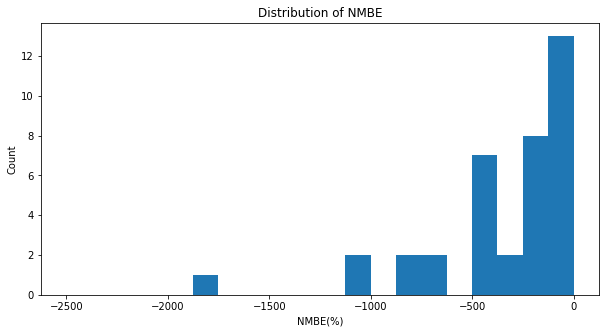

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(nmbe, bins=20, range=[-2500,0])
plt.title('Distribution of NMBE')
plt.xlabel('NMBE(%)')
plt.ylabel('Count');
plt.savefig('Dist_NMBE_Basic.png')


In [39]:
abigailX = pd.read_csv('/Users/cgroschner/Desktop/pdTrainX.csv')
abigailX = abigailX[abigailX['building_name']=='Office_Abigail']
abigailY = pd.read_csv('/Users/cgroschner/Desktop/pdTrainY.csv')
abigailY = abigailY[abigailY['building_name']=='Office_Abigail']

In [40]:
abigailX = reshape_input(abigailX,drop_col)

In [41]:
abigailY = reshape_output(abigailY)

In [42]:
abigail_pred = model.predict(abigailX[:,:,0:1])

In [43]:
abigailY.shape

(1, 6600)

In [44]:
abigail_pred.shape

(1, 6600)

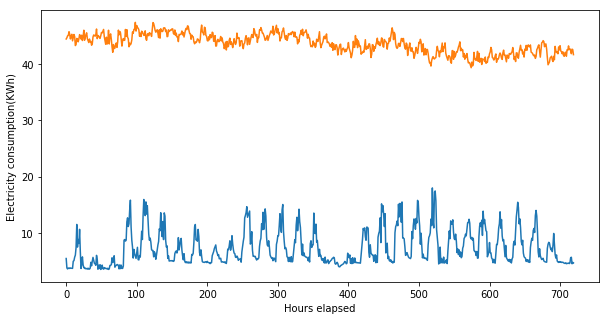

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(abigailY[0][:720], label='observed')
plt.plot(abigail_pred[0][:720], label='predicted')
plt.ylabel('Electricity consumption(KWh)')
plt.xlabel('Hours elapsed')
# plt.legend();
plt.savefig('lstmBasic_officeAbigail.png')